In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
DATA_DIR = './'

TRAIN_DIR = f'{DATA_DIR}/train'
TEST_DIR = f'{DATA_DIR}/test'

PLOTS_DIR = f'{DATA_DIR}/plots'

OUTPUT_DIR = f'{DATA_DIR}/output'
MODEL_CHECKPOINT_DIR = f'{DATA_DIR}/models'

In [3]:
import os.path
from os import path

for pth in [TRAIN_DIR, TEST_DIR, OUTPUT_DIR, MODEL_CHECKPOINT_DIR]:
    if path.exists(pth) == False:
        os.mkdir(pth)


In [4]:
import pandas as pd
import numpy as np


train = pd.read_csv(f'{TRAIN_DIR}/Train.csv')
desc = pd.read_csv(f'{DATA_DIR}/DataDictionary.csv')

### Exploratory Analysis

In [42]:

CAT = desc[36:]['Column Name'].tolist()
train_df = train.drop(columns=CAT)

In [78]:
timespan = train_df.groupby('sku_name').size()
max_len = timespan.max()
sample = list(set(timespan[timespan>=(max_len*.6)].index.tolist()))

In [76]:
exp_train = train_df.copy()
exp_train['date'] = exp_train['month'].astype(str)+'/'+exp_train['year'].astype(str)
exp_train = exp_train.set_index(exp_train['date'])

In [44]:
train_df[train_df['sku_name']==sample[15]].sort_values(['year','month'])

,sku_name,starting_inventory,sellin,sellin_channel_1,sellin_channel_2,sellin_channel_3,sellin_channel_4,sellin_channel_5,sellin_channel_6,sellin_channel_7,...,onhand_inventory_channel_4,onhand_inventory_channel_5,onhand_inventory_channel_6,onhand_inventory_channel_7,onhand_inventory_channel_8,onhand_inventory_channel_9,onhand_inventory_channel_10,price,month,year
21401,KEVAROBRIGO,0,864089,462941,232990,28364,0,0,9117,15195,...,3039,375823,0,124599,1013,398109,151950,155,1,2016
21402,KEVAROBRIGO,0,530812,258315,22286,24312,0,20260,19247,71923,...,3039,206652,0,123586,0,397096,150937,155,2,2016
21403,KEVAROBRIGO,0,939051,270471,228938,18234,0,60780,13169,304913,...,2026,333277,0,132703,0,434577,143846,155,3,2016
21404,KEVAROBRIGO,0,605774,249198,259328,20260,3039,6078,15195,4052,...,2026,298835,0,114469,0,210704,143846,155,4,2016
21405,KEVAROBRIGO,0,488266,285666,25325,25325,2026,60780,8104,12156,...,2026,278575,0,119534,0,148911,135742,155,5,2016
21406,KEVAROBRIGO,0,889414,535877,75975,44572,0,79014,13169,42546,...,2026,303900,0,117508,2026,166132,130677,155,6,2016
21407,KEVAROBRIGO,0,658450,378862,7091,31403,1013,0,11143,78001,...,1013,315043,0,131690,1013,99274,144859,155,7,2016
21408,KEVAROBRIGO,0,546007,301874,22286,49637,1013,81040,12156,15195,...,7091,192470,0,108391,0,94209,157015,155,8,2016
21409,KEVAROBRIGO,0,1007935,612865,52676,69897,4052,131690,20260,20260,...,5065,308965,0,96235,0,100287,177275,155,9,2016
21410,KEVAROBRIGO,0,911700,707074,43559,39507,0,0,16208,3039,...,4052,346446,0,93196,0,89144,170184,155,10,2016


In [48]:
target = 'sellin'
factors = [c for c in train_df.columns if 'channel' not in c and c not in ['sku_name','month','year','sellin']]

In [51]:
train_df[train_df['sku_name']==sample[15]].sort_values(['year','month'])[factors+['month','year']]

,starting_inventory,sellout,onhand_inventory,leftover_inventory,price,month,year
21401,0,534864,3319601,329225,155,1,2016
21402,0,501435,3145365,29377,155,2,2016
21403,0,462941,3167651,476110,155,3,2016
21404,0,416343,2822218,189431,155,4,2016
21405,0,459902,2740165,28364,155,5,2016
21406,0,492318,2646969,397096,155,6,2016
21407,0,400135,2562890,258315,155,7,2016
21408,0,396083,2532500,149924,155,8,2016
21409,0,530812,2460577,477123,155,9,2016
21410,0,378862,2546682,532838,155,10,2016


<AxesSubplot:>

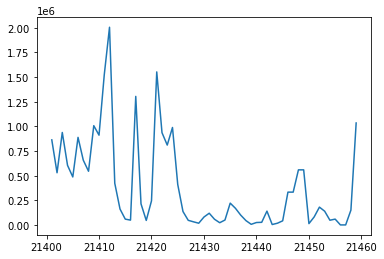

In [58]:
train_df[train_df['sku_name']==sample[15]].sort_values(['year','month'])[factors+['month','year','sellin']]['sellin'].plot()

array([<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>],
      dtype=object)

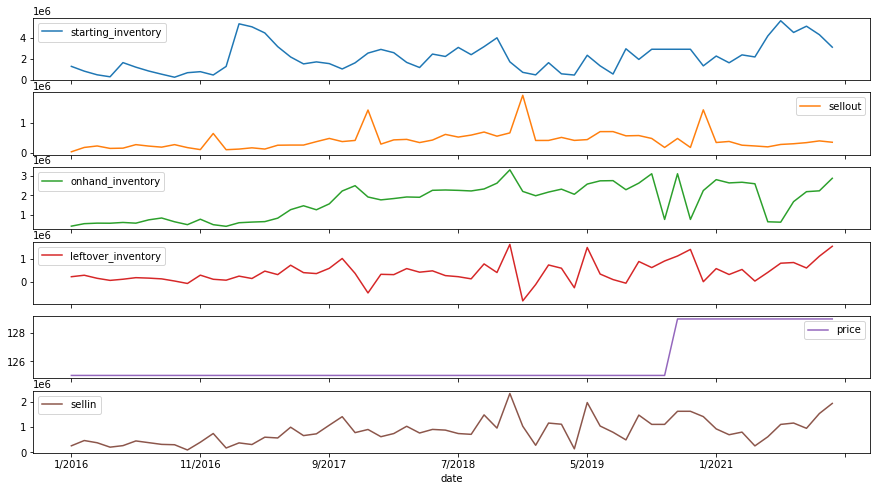

In [88]:
exp_train[exp_train['sku_name']==sample[89]].sort_values(['year','month'])[factors+['sellin']].plot(subplots=True, figsize=(15,8))

## Base Models

### Preprocessing

In [5]:

CAT = desc[36:]['Column Name'].tolist()
train_df = train.drop(columns=CAT)

In [6]:
from fossil.preprocessing import FossilPreprocessor, LabelEncoder
from fossil.config import ModelsConfig

np.random.seed(ModelsConfig.SEED)
sku_encoder = LabelEncoder(train.sku_name.sample(frac=0.95, random_state=ModelsConfig.SEED).unique())

#save dictionary of items for use during inference
sku_encoder.save_items(f'{OUTPUT_DIR}/sku_dict.pkl')

fossil_preproc = FossilPreprocessor(sku_encoder)

In [7]:
dates = fossil_preproc.sort_dates(train_df)
train_df = fossil_preproc.extract_relative_features(train_df)

In [8]:

primary_data = fossil_preproc.prepare_primary_data(train_df, dates, False, OUTPUT_DIR)
base_data = fossil_preproc.impute_missing(primary_data, False, OUTPUT_DIR)

  0%|          | 0/3868 [00:00<?, ?it/s]

  0%|          | 0/3868 [00:00<?, ?it/s]

  0%|          | 0/3868 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/3868 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/3868 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

In [16]:

#store features from latest date for use as context during inference
context = primary_data[['month','year']].apply(tuple, axis=1).isin(dates[-ModelsConfig.LOOKBACK:])
primary_data[context].to_csv(f'{OUTPUT_DIR}/context.csv', index=False)

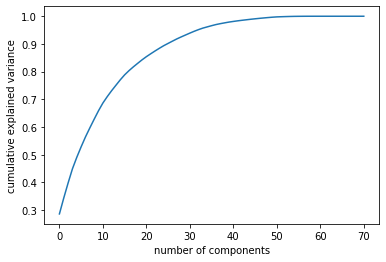

In [10]:
fossil_preproc.pca_feature_selection(base_data, eda=True)

In [11]:
principal_features = fossil_preproc.pca_feature_selection(base_data, 50)

#save features for inference
fossil_preproc.save_items(f'{OUTPUT_DIR}/principal_features.pkl', principal_features)

### Training

In [14]:
from fossil.models.gbdt import FossilGBDT
gbdt_models = FossilGBDT()

oof_preds, cv_models, blended_mae = gbdt_models.blend_cv_models(principal_features, base_data, fossil_preproc)

Training lgb model for timestep 1 forecasting


Training fold 1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[262]	training's l1: 108778	valid_1's l1: 153917


Training fold 2
Training until validation scores don't improve for 5 rounds
[500]	training's l1: 88193.6	valid_1's l1: 118949
Early stopping, best iteration is:
[663]	training's l1: 80184.4	valid_1's l1: 117452


Training fold 3
Training until validation scores don't improve for 5 rounds
[500]	training's l1: 86116.1	valid_1's l1: 129129
Early stopping, best iteration is:
[590]	training's l1: 81433	valid_1's l1: 128136
Elapsed 0.11 mins
--------------------------------------------------


Training lgb model for timestep 2 forecasting


Training fold 1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[415]	training's l1: 89253.5	valid_1's l1: 152350


Training fold 2
Training until validation scores don't improve for 5 rounds
[500]	trai

In [12]:
from fossil.models.gbdt import FossilGBDT
gbdt_models = FossilGBDT()

oof_preds, cv_models, blended_mae = gbdt_models.blend_cv_models(principal_features, base_data, fossil_preproc)

Training lgb model for timestep 1 forecasting


Training fold 1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[380]	training's l1: 92357.4	valid_1's l1: 147278


Training fold 2
Training until validation scores don't improve for 5 rounds
[500]	training's l1: 88103.2	valid_1's l1: 119682
Early stopping, best iteration is:
[717]	training's l1: 78049.8	valid_1's l1: 118029


Training fold 3
Training until validation scores don't improve for 5 rounds
[500]	training's l1: 86603.1	valid_1's l1: 127915
Early stopping, best iteration is:
[752]	training's l1: 75779.7	valid_1's l1: 125971
Elapsed 0.14 mins
--------------------------------------------------


Training lgb model for timestep 2 forecasting


Training fold 1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[405]	training's l1: 89652.5	valid_1's l1: 146899


Training fold 2
Training until validation scores don't improve for 5 rounds
[500]	t

In [46]:
gbdt_models.save_cv_models(cv_models, MODEL_CHECKPOINT_DIR)

### Walk Forward Validation

In [175]:
from fossil.models.gbdt import FossilGBDT
from fossil.config import ModelsConfig
from fossil.inference import make_predictions, prepare_test_context

gbdt_models = FossilGBDT()

target_cols = [f'target_{i}' for i in range(ModelsConfig.N_STEPS)]
pred_cols = [f'preds_{i}' for i in range(ModelsConfig.N_STEPS)]

principal_features = fossil_preproc.load_saved_items(f'{OUTPUT_DIR}/principal_features.pkl')
cols = principal_features+['month','year']

non_features = ['sku_name','sku_coded']+target_cols
test = pd.read_csv(f'{TEST_DIR}/Test.csv')

walk_forward_steps = len(dates)-ModelsConfig.N_STEPS-1

mae_dict = dict(
    month=[], 
    year=[], 
    Walk_forward_mae=[], 
    train_sku_count=[], 
    val_sku_count=[],
    new_sku = [])

for step in range(walk_forward_steps,0,-4):
    train_dates = dates[:-(ModelsConfig.N_STEPS+step)]
    val_dates = dates[-(ModelsConfig.N_STEPS+step):-step]
    
    if len(train_dates)<ModelsConfig.FOLDS:
        continue
        
    train_data = base_data[base_data[['month','year']].apply(tuple,axis=1).isin(train_dates)]
    val_context = base_data[base_data[['month','year']].apply(tuple,axis=1).isin([train_dates[-1]])]

    val = base_data[base_data[['month','year']].apply(tuple,axis=1).isin(val_dates)]
    val_context, _ = prepare_test_context(val_context, val, fossil_preproc)
    
    val_data = fossil_preproc.impute_missing(val_context, True, OUTPUT_DIR)
    mae_dict['train_sku_count'].append(train_data['sku_name'].nunique())
    mae_dict['val_sku_count'].append(val['sku_name'].nunique())
    
    val_data = val_data[val_data['sku_name'].isin(val['sku_name'].unique())]
    y_true = val_data[[f'target_{i}' for i in range(ModelsConfig.N_STEPS)]].values.reshape(-1,)
    
    new_sku = set(val['sku_name'].unique()).difference(train_data['sku_name'].unique())
    feature_cols = [c for c in base_data.columns if c not in non_features and c in cols]

    oof_preds, cv_models, blended_mae = gbdt_models.blend_cv_models(principal_features, train_data, fossil_preproc)
    sub_df = make_predictions(val, val_data, feature_cols, target_cols, pred_cols, cv_models)
    
    walk_forward_mae = np.absolute(np.subtract(sub_df['Target'], y_true)).mean()
    
    mae_dict['month'].append(val_dates[-1][0])
    mae_dict['year'].append(val_dates[-1][1])
    mae_dict['Walk_forward_mae'].append(walk_forward_mae)
    mae_dict['new_sku'].append(len(new_sku))
    
    print("Walk forward MAE: ",walk_forward_mae)

  0%|          | 0/1976 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Training lgb model for timestep 1 forecasting


Training fold 1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[269]	training's l1: 98718.5	valid_1's l1: 121310


Training fold 2
Training until validation scores don't improve for 5 rounds
[500]	training's l1: 52942	valid_1's l1: 139219
Early stopping, best iteration is:
[641]	training's l1: 47190	valid_1's l1: 136694


Training fold 3
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[299]	training's l1: 75113.1	valid_1's l1: 141033
Elapsed 0.04 mins
--------------------------------------------------


Training lgb model for timestep 2 forecasting


Training fold 1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[486]	training's l1: 60494.3	valid_1's l1: 98833.8


Training fold 2
Training until validation scores don't improve for 5 rounds
[500]	training's l1: 57054.5	valid_1's l1: 121886
Early stop

  0%|          | 0/1928 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Training lgb model for timestep 1 forecasting


Training fold 1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[249]	training's l1: 87471.1	valid_1's l1: 173746


Training fold 2
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[491]	training's l1: 56909.4	valid_1's l1: 122354


Training fold 3
Training until validation scores don't improve for 5 rounds
[500]	training's l1: 56095.1	valid_1's l1: 103280
Early stopping, best iteration is:
[654]	training's l1: 49258.9	valid_1's l1: 101596
Elapsed 0.07 mins
--------------------------------------------------


Training lgb model for timestep 2 forecasting


Training fold 1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[261]	training's l1: 80109.5	valid_1's l1: 200926


Training fold 2
Training until validation scores don't improve for 5 rounds
[500]	training's l1: 60114.6	valid_1's l1: 115708
Early s

  0%|          | 0/1564 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Training lgb model for timestep 1 forecasting


Training fold 1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[116]	training's l1: 161054	valid_1's l1: 264027


Training fold 2
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[440]	training's l1: 73259	valid_1's l1: 132897


Training fold 3
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[446]	training's l1: 67239.2	valid_1's l1: 151337
Elapsed 0.06 mins
--------------------------------------------------


Training lgb model for timestep 2 forecasting


Training fold 1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[23]	training's l1: 266165	valid_1's l1: 346815


Training fold 2
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[493]	training's l1: 68701	valid_1's l1: 132362


Training fold 3
Training un

  0%|          | 0/1259 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Training lgb model for timestep 1 forecasting


Training fold 1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[186]	training's l1: 116899	valid_1's l1: 229728


Training fold 2
Training until validation scores don't improve for 5 rounds
[500]	training's l1: 68183.2	valid_1's l1: 116270
Early stopping, best iteration is:
[617]	training's l1: 61092.6	valid_1's l1: 114984


Training fold 3
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[380]	training's l1: 79783.6	valid_1's l1: 145416
Elapsed 0.08 mins
--------------------------------------------------


Training lgb model for timestep 2 forecasting


Training fold 1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[107]	training's l1: 169919	valid_1's l1: 265984


Training fold 2
Training until validation scores don't improve for 5 rounds
[500]	training's l1: 62897.4	valid_1's l1: 127661
Early sto

  0%|          | 0/1054 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Training lgb model for timestep 1 forecasting


Training fold 1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[447]	training's l1: 72277.7	valid_1's l1: 151805


Training fold 2
Training until validation scores don't improve for 5 rounds
[500]	training's l1: 72314.6	valid_1's l1: 128564
Early stopping, best iteration is:
[684]	training's l1: 61427.9	valid_1's l1: 126670


Training fold 3
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[483]	training's l1: 69142.4	valid_1's l1: 151023
Elapsed 0.11 mins
--------------------------------------------------


Training lgb model for timestep 2 forecasting


Training fold 1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[489]	training's l1: 75751	valid_1's l1: 134644


Training fold 2
Training until validation scores don't improve for 5 rounds
[500]	training's l1: 64012.2	valid_1's l1: 153512
Early sto

  0%|          | 0/944 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Training lgb model for timestep 1 forecasting


Training fold 1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[314]	training's l1: 94380.4	valid_1's l1: 155853


Training fold 2
Training until validation scores don't improve for 5 rounds
[500]	training's l1: 74094.9	valid_1's l1: 131230
Early stopping, best iteration is:
[629]	training's l1: 65942.7	valid_1's l1: 130079


Training fold 3
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[417]	training's l1: 81660.1	valid_1's l1: 141387
Elapsed 0.09 mins
--------------------------------------------------


Training lgb model for timestep 2 forecasting


Training fold 1
Training until validation scores don't improve for 5 rounds
[500]	training's l1: 77650.5	valid_1's l1: 125069
Early stopping, best iteration is:
[595]	training's l1: 71104.4	valid_1's l1: 123858


Training fold 2
Training until validation scores don't improve for 5 rounds
[500]	t

  0%|          | 0/1112 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Training lgb model for timestep 1 forecasting


Training fold 1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[304]	training's l1: 90525.6	valid_1's l1: 161768


Training fold 2
Training until validation scores don't improve for 5 rounds
[500]	training's l1: 77696.2	valid_1's l1: 118821
Early stopping, best iteration is:
[638]	training's l1: 69129.2	valid_1's l1: 117264


Training fold 3
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[441]	training's l1: 79528.1	valid_1's l1: 136779
Elapsed 0.10 mins
--------------------------------------------------


Training lgb model for timestep 2 forecasting


Training fold 1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[463]	training's l1: 76796.5	valid_1's l1: 133494


Training fold 2
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[476]	training's l1: 7

  0%|          | 0/1080 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Training lgb model for timestep 1 forecasting


Training fold 1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[395]	training's l1: 81626.8	valid_1's l1: 143121


Training fold 2
Training until validation scores don't improve for 5 rounds
[500]	training's l1: 73680.7	valid_1's l1: 131020
Early stopping, best iteration is:
[586]	training's l1: 68672.1	valid_1's l1: 130012


Training fold 3
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[432]	training's l1: 83870.2	valid_1's l1: 132030
Elapsed 0.11 mins
--------------------------------------------------


Training lgb model for timestep 2 forecasting


Training fold 1
Training until validation scores don't improve for 5 rounds
[500]	training's l1: 78302.8	valid_1's l1: 125936
Early stopping, best iteration is:
[582]	training's l1: 73069.7	valid_1's l1: 125183


Training fold 2
Training until validation scores don't improve for 5 rounds
[500]	t

  0%|          | 0/1003 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Training lgb model for timestep 1 forecasting


Training fold 1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[357]	training's l1: 88217.5	valid_1's l1: 146606


Training fold 2
Training until validation scores don't improve for 5 rounds
[500]	training's l1: 77223.6	valid_1's l1: 128445
Early stopping, best iteration is:
[572]	training's l1: 72806.6	valid_1's l1: 127820


Training fold 3
Training until validation scores don't improve for 5 rounds
[500]	training's l1: 80860.1	valid_1's l1: 125207
Early stopping, best iteration is:
[619]	training's l1: 73734.2	valid_1's l1: 123820
Elapsed 0.12 mins
--------------------------------------------------


Training lgb model for timestep 2 forecasting


Training fold 1
Training until validation scores don't improve for 5 rounds
[500]	training's l1: 81180.7	valid_1's l1: 129561
Early stopping, best iteration is:
[673]	training's l1: 71685.2	valid_1's l1: 128122


Training fold 2
Training until va

  0%|          | 0/1039 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Training lgb model for timestep 1 forecasting


Training fold 1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[350]	training's l1: 93811.2	valid_1's l1: 142115


Training fold 2
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[462]	training's l1: 80157.9	valid_1's l1: 126384


Training fold 3
Training until validation scores don't improve for 5 rounds
[500]	training's l1: 80084	valid_1's l1: 131172
Early stopping, best iteration is:
[703]	training's l1: 69934	valid_1's l1: 129287
Elapsed 0.12 mins
--------------------------------------------------


Training lgb model for timestep 2 forecasting


Training fold 1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[397]	training's l1: 91146.1	valid_1's l1: 131789


Training fold 2
Training until validation scores don't improve for 5 rounds
[500]	training's l1: 73319	valid_1's l1: 132236
Early stoppin

  0%|          | 0/1223 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Training lgb model for timestep 1 forecasting


Training fold 1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[438]	training's l1: 85539.7	valid_1's l1: 142073


Training fold 2
Training until validation scores don't improve for 5 rounds
[500]	training's l1: 81614	valid_1's l1: 120458
Early stopping, best iteration is:
[701]	training's l1: 71801.9	valid_1's l1: 118684


Training fold 3
Training until validation scores don't improve for 5 rounds
[500]	training's l1: 80570.3	valid_1's l1: 133849
Early stopping, best iteration is:
[603]	training's l1: 75170.2	valid_1's l1: 132463
Elapsed 0.15 mins
--------------------------------------------------


Training lgb model for timestep 2 forecasting


Training fold 1
Training until validation scores don't improve for 5 rounds
[500]	training's l1: 81409.1	valid_1's l1: 134159
Early stopping, best iteration is:
[497]	training's l1: 81589.3	valid_1's l1: 134105


Training fold 2
Training until vali

  0%|          | 0/818 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Training lgb model for timestep 1 forecasting


Training fold 1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[379]	training's l1: 90131.2	valid_1's l1: 145394


Training fold 2
Training until validation scores don't improve for 5 rounds
[500]	training's l1: 82860.9	valid_1's l1: 123256
Early stopping, best iteration is:
[596]	training's l1: 77657.5	valid_1's l1: 122610


Training fold 3
Training until validation scores don't improve for 5 rounds
[500]	training's l1: 83182.4	valid_1's l1: 133825
Early stopping, best iteration is:
[553]	training's l1: 80194.5	valid_1's l1: 133133
Elapsed 0.13 mins
--------------------------------------------------


Training lgb model for timestep 2 forecasting


Training fold 1
Training until validation scores don't improve for 5 rounds
[500]	training's l1: 83795.4	valid_1's l1: 126436
Early stopping, best iteration is:
[671]	training's l1: 75276.7	valid_1's l1: 125069


Training fold 2
Training until va

  0%|          | 0/883 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Training lgb model for timestep 1 forecasting


Training fold 1
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[344]	training's l1: 97882.8	valid_1's l1: 142573


Training fold 2
Training until validation scores don't improve for 5 rounds
[500]	training's l1: 83198.4	valid_1's l1: 122483
Early stopping, best iteration is:
[663]	training's l1: 75210.6	valid_1's l1: 121674


Training fold 3
Training until validation scores don't improve for 5 rounds
[500]	training's l1: 81483.4	valid_1's l1: 139148
Early stopping, best iteration is:
[589]	training's l1: 77053.3	valid_1's l1: 137997
Elapsed 0.14 mins
--------------------------------------------------


Training lgb model for timestep 2 forecasting


Training fold 1
Training until validation scores don't improve for 5 rounds
[500]	training's l1: 87282.4	valid_1's l1: 129647
Early stopping, best iteration is:
[561]	training's l1: 83847.6	valid_1's l1: 129253


Training fold 2
Training until va

In [204]:
eval_df = pd.DataFrame(mae_dict)

<AxesSubplot:xlabel='new_sku'>

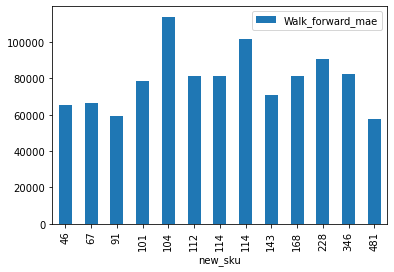

In [208]:
eval_df.sort_values('new_sku').plot.bar(x='new_sku',y='Walk_forward_mae')

array([<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>],
      dtype=object)

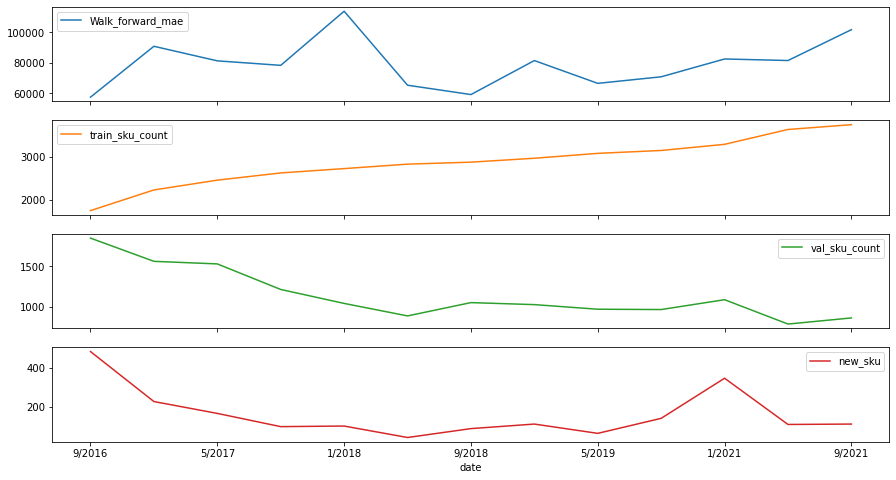

In [215]:

eval_df['date'] = eval_df['month'].astype(str)+'/'+eval_df['year'].astype(str)
# exp_train = exp_train.set_index(exp_train['date'])

eval_df.sort_values(['year','month']).set_index(eval_df['date']).drop(columns=['month','year']).plot(subplots=True, figsize=(15,8))

In [211]:
eval_df

,month,year,Walk_forward_mae,train_sku_count,val_sku_count,new_sku,date
0,9,2016,57474.059957,1743,1850,481,9/2016
1,1,2017,90878.891478,2224,1562,228,1/2017
2,5,2017,81314.899357,2452,1530,168,5/2017
3,9,2017,78364.233073,2620,1213,101,9/2017
4,1,2018,113908.782686,2721,1040,104,1/2018
5,5,2018,65319.875505,2825,885,46,5/2018
6,9,2018,59185.234112,2871,1050,91,9/2018
7,1,2019,81508.232727,2962,1025,114,1/2019
8,5,2019,66541.421563,3076,968,67,5/2019
9,9,2019,70842.699839,3143,964,143,9/2019


## Inference

In [17]:
DATA_DIR = './'

TRAIN_DIR = f'{DATA_DIR}/train'
TEST_DIR = f'{DATA_DIR}/test'

PLOTS_DIR = f'{DATA_DIR}/plots'

OUTPUT_DIR = f'{DATA_DIR}/output'
MODEL_CHECKPOINT_DIR = f'{DATA_DIR}/models'

In [18]:
import pandas as pd 
import numpy as np

test = pd.read_csv(f'{TEST_DIR}/Test.csv')
context = pd.read_csv(f'{OUTPUT_DIR}/context.csv')

In [19]:
from fossil.inference import prepare_test_context
from fossil.config import ModelsConfig
from fossil.preprocessing import FossilPreprocessor, LabelEncoder

np.random.seed(ModelsConfig.SEED)
sku_encoder = LabelEncoder(save_path=f'{OUTPUT_DIR}/sku_dict.pkl')


fossil_preproc = FossilPreprocessor(sku_encoder)
test_context, test_dates = prepare_test_context(context, test, fossil_preproc)

In [20]:
feature_cols = [c for c in test_context.columns if c not in ['sku_name', 'month', 'year']
             and all(l not in c for l in ['target', 'channel','rel'])]

dates = fossil_preproc.sort_dates(test_context)
test_data = fossil_preproc.prepare_primary_data(test_context, dates, True, OUTPUT_DIR)

  0%|          | 0/641 [00:00<?, ?it/s]

  0%|          | 0/641 [00:00<?, ?it/s]

  0%|          | 0/641 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

C:\Users\nelso\OneDrive\Documents\Misc\Fossil\implementation\Round 2\fossil\preprocessing.py:181: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_{period}month_MM'] = group.transform(lambda x: x.rolling(period).median())
C:\Users\nelso\OneDrive\Documents\Misc\Fossil\implementation\Round 2\fossil\preprocessing.py:181: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{col}_{period}month_MM'] = group.transform(lambda x: x.rolling(period).median())
C:\Users\nelso\OneDrive\Documents\Misc\Fossil\implementation\Round 2\fossi

  0%|          | 0/641 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [21]:
test_data = fossil_preproc.impute_missing(test_context, True, OUTPUT_DIR)

  0%|          | 0/641 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [22]:
test_data = test_data[test_data[['month', 'year']].apply(tuple, axis=1).isin(test_dates)]

In [23]:
target_cols = [f'target_{i}' for i in range(ModelsConfig.N_STEPS)]
pred_cols = [f'preds_{i}' for i in range(ModelsConfig.N_STEPS)]

principal_features = fossil_preproc.load_saved_items(f'{OUTPUT_DIR}/principal_features.pkl')
cols = principal_features+['month','year']

non_features = ['sku_name','sku_coded']+target_cols
feature_cols = [c for c in test_data.columns if c not in non_features and c in cols]

In [22]:
# from fossil.models.gbdt import FossilGBDT
# gbdt_models = FossilGBDT()

# cv_models = 

In [24]:
from fossil.inference import make_predictions

sub_df = make_predictions(test, test_data, feature_cols, target_cols, pred_cols, cv_models)

In [19]:
# save_name = f'{OUTPUT_DIR}/fossil_{ModelsConfig.BASE_MODEL}_{ModelsConfig.META_LEARNER}_{secondary_val_mae}.csv'
# sub_df[['Item_ID','Target']].to_csv(save_name, index=False)

In [30]:
save_name = f'{OUTPUT_DIR}/fossil_blended_{blended_mae}.csv'
sub_df[sub_df['time_step']==3][['Item_ID','Target']].to_csv(save_name, index=False)

In [25]:
sub_df[sub_df['time_step']==3].sort_values(['sku_name','year','month'])#[['month','year','pred_month','pred_year']]

,sku_name,month,year,starting_inventory,sellin,sellin_channel_1,sellin_channel_2,sellin_channel_3,sellin_channel_4,sellin_channel_5,...,onhand_inventory_9month_MM,leftover_inventory_6month_MM,leftover_inventory_9month_MM,price_6month_MM,price_9month_MM,sku_coded,preds,time_step,Target,Item_ID
3,ABEAHAMASHL,2,2022,410265.0,18234.0,0.0,0.0,0.0,1013.0,0.0,...,291744.0,-13675.5,-16208.0,149.0,149.0,74.0,68466.153822,3,113753.488072,ABEAHAMASHL_2_2022
7,ABEENNEARMAZZ,2,2022,42546.0,152963.0,58754.0,35455.0,0.0,0.0,0.0,...,600709.0,68884.0,106365.0,129.0,129.0,633.0,106618.154844,3,129210.452511,ABEENNEARMAZZ_2_2022
11,ABEETTEABE,2,2022,3352017.0,1211548.0,1095053.0,61793.0,0.0,0.0,0.0,...,2452473.0,534357.5,490292.0,159.0,159.0,789.0,857977.897245,3,866790.346150,ABEETTEABE_2_2022
15,ABERTHAKEVAZZ,2,2022,2366368.0,749620.0,729360.0,15195.0,0.0,0.0,0.0,...,633125.0,31909.5,59260.5,135.0,135.0,3640.0,152722.423691,3,145051.754819,ABERTHAKEVAZZ_2_2022
19,ABEWARDREYZZ,2,2022,153976.0,47611.0,31403.0,0.0,0.0,0.0,0.0,...,633125.0,31909.5,59260.5,135.0,135.0,3241.0,76576.441269,3,96179.506677,ABEWARDREYZZ_2_2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1479,WHITSHIAALBEZZ,2,2022,888401.0,52676.0,13169.0,0.0,0.0,0.0,0.0,...,809387.0,14688.5,25325.0,169.0,169.0,1422.0,127199.317982,3,161279.340144,WHITSHIAALBEZZ_2_2022
1483,YOSHILSEHOWAZZ,2,2022,246159.0,6078.0,0.0,0.0,0.0,0.0,0.0,...,633125.0,31909.5,59260.5,135.0,135.0,3586.0,63802.508036,3,79745.712803,YOSHILSEHOWAZZ_2_2022
1487,YOSHLEENBART,2,2022,1664359.0,111430.0,67871.0,31403.0,0.0,0.0,0.0,...,251224.0,171703.5,141820.0,129.0,129.0,725.0,219712.609461,3,326844.284459,YOSHLEENBART_2_2022
1491,YOSHRENECARL,2,2022,1527604.0,288705.0,199561.0,79014.0,0.0,0.0,0.0,...,793179.0,211717.0,214756.0,129.0,129.0,248.0,345479.449555,3,361741.691253,YOSHRENECARL_2_2022


In [29]:
sub_df[sub_df['time_step']==3].sort_values(['sku_name','year','month'])#[['month','year','pred_month','pred_year']]

,sku_name,month,year,starting_inventory,sellin,sellin_channel_1,sellin_channel_2,sellin_channel_3,sellin_channel_4,sellin_channel_5,...,onhand_inventory_9month_MM,leftover_inventory_6month_MM,leftover_inventory_9month_MM,price_6month_MM,price_9month_MM,sku_coded,preds,time_step,Target,Item_ID
3,ABEAHAMASHL,2,2022,410265.0,18234.0,0.0,0.0,0.0,1013.0,0.0,...,291744.0,-13675.5,-16208.0,149.0,149.0,74.0,64061.189814,3,87739.876614,ABEAHAMASHL_2_2022
7,ABEENNEARMAZZ,2,2022,42546.0,152963.0,58754.0,35455.0,0.0,0.0,0.0,...,600709.0,68884.0,106365.0,129.0,129.0,633.0,73715.354114,3,86970.214678,ABEENNEARMAZZ_2_2022
11,ABEETTEABE,2,2022,3352017.0,1211548.0,1095053.0,61793.0,0.0,0.0,0.0,...,2452473.0,534357.5,490292.0,159.0,159.0,789.0,713315.822861,3,588224.038332,ABEETTEABE_2_2022
15,ABERTHAKEVAZZ,2,2022,2366368.0,749620.0,729360.0,15195.0,0.0,0.0,0.0,...,621475.5,28364.0,49637.0,135.0,135.0,3640.0,106270.258608,3,106138.805276,ABERTHAKEVAZZ_2_2022
19,ABEWARDREYZZ,2,2022,153976.0,47611.0,31403.0,0.0,0.0,0.0,0.0,...,621475.5,28364.0,49637.0,135.0,135.0,3241.0,52147.223107,3,61330.631241,ABEWARDREYZZ_2_2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1479,WHITSHIAALBEZZ,2,2022,888401.0,52676.0,13169.0,0.0,0.0,0.0,0.0,...,809387.0,14688.5,25325.0,169.0,169.0,1422.0,86019.201900,3,105930.560681,WHITSHIAALBEZZ_2_2022
1483,YOSHILSEHOWAZZ,2,2022,246159.0,6078.0,0.0,0.0,0.0,0.0,0.0,...,621475.5,28364.0,49637.0,135.0,135.0,3586.0,49965.981924,3,50497.404207,YOSHILSEHOWAZZ_2_2022
1487,YOSHLEENBART,2,2022,1664359.0,111430.0,67871.0,31403.0,0.0,0.0,0.0,...,251224.0,171703.5,141820.0,129.0,129.0,725.0,178213.334488,3,201740.085247,YOSHLEENBART_2_2022
1491,YOSHRENECARL,2,2022,1527604.0,288705.0,199561.0,79014.0,0.0,0.0,0.0,...,793179.0,211717.0,214756.0,129.0,129.0,248.0,221611.377967,3,220856.688688,YOSHRENECARL_2_2022


In [18]:
sub_df#[['month','year','pred_month','pred_year']]

,sku_name,month,year,starting_inventory,sellin,sellin_channel_1,sellin_channel_2,sellin_channel_3,sellin_channel_4,sellin_channel_5,...,onhand_inventory_9month_MM,leftover_inventory_6month_MM,leftover_inventory_9month_MM,price_6month_MM,price_9month_MM,sku_coded,preds,time_step,Target,Item_ID
0,ABEAHAMASHL,11,2021,410265.0,18234.0,0.0,0.0,0.0,1013.0,0.0,...,291744.0,-13675.5,-16208.0,149.0,149.0,74.0,35072.725079,0,47640.930020,ABEAHAMASHL_11_2021
1,ABEAHAMASHL,12,2021,410265.0,18234.0,0.0,0.0,0.0,1013.0,0.0,...,291744.0,-13675.5,-16208.0,149.0,149.0,74.0,44672.654183,1,77943.376682,ABEAHAMASHL_12_2021
2,ABEAHAMASHL,1,2022,410265.0,18234.0,0.0,0.0,0.0,1013.0,0.0,...,291744.0,-13675.5,-16208.0,149.0,149.0,74.0,43210.416403,2,87058.224649,ABEAHAMASHL_1_2022
3,ABEAHAMASHL,2,2022,410265.0,18234.0,0.0,0.0,0.0,1013.0,0.0,...,291744.0,-13675.5,-16208.0,149.0,149.0,74.0,56187.085045,3,79939.259651,ABEAHAMASHL_2_2022
4,ABEENNEARMAZZ,11,2021,42546.0,152963.0,58754.0,35455.0,0.0,0.0,0.0,...,600709.0,68884.0,106365.0,129.0,129.0,633.0,159290.384286,0,203265.296056,ABEENNEARMAZZ_11_2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1523,YOSHRENECARL,2,2022,1527604.0,288705.0,199561.0,79014.0,0.0,0.0,0.0,...,793179.0,211717.0,214756.0,129.0,129.0,248.0,207297.427046,3,223475.074890,YOSHRENECARL_2_2022
1524,YOSHTLYNYOSHZZ,11,2021,156002.0,163093.0,122573.0,30390.0,0.0,0.0,0.0,...,193483.0,180820.5,200574.0,149.0,149.0,1852.0,205218.138990,0,220793.851680,YOSHTLYNYOSHZZ_11_2021
1525,YOSHTLYNYOSHZZ,12,2021,156002.0,163093.0,122573.0,30390.0,0.0,0.0,0.0,...,193483.0,180820.5,200574.0,149.0,149.0,1852.0,196515.846253,1,223099.976004,YOSHTLYNYOSHZZ_12_2021
1526,YOSHTLYNYOSHZZ,1,2022,156002.0,163093.0,122573.0,30390.0,0.0,0.0,0.0,...,193483.0,180820.5,200574.0,149.0,149.0,1852.0,140360.727007,2,189837.577327,YOSHTLYNYOSHZZ_1_2022
